# Sistem Rekomendasi Destinasi Wisata dengan Collaborative Filtering
<hr>

#### Sumber data: https://www.kaggle.com/aprabowo/indonesia-tourism-destination

## 1. Mengimpor Library Python yang Dibutuhkan

In [ ]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

In [ ]:
# Upload semua dataset yang dipakai
import pandas as pd
rating = pd.read_csv('tourism_rating.csv')
place = pd.read_csv('tourism_with_id.csv')
user = pd.read_csv('user.csv')

##### Keterangan:
* tourism_with_id.csv - mengandung informasi tempak wisata di 5 kota besar di Indonesia
* user.csv - mengandung informasi pengguna untuk membuat rekomendasi fitur berdasar pengguna
* tourism_rating.csv - mengandung informasi pengguna, tempat wisata, dan rating untuk membuat sistem rekomendasi berdasar rating


## 3. Data Understanding

### 3.1 Menyiapkan Data

In [ ]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicates : ", duplicate_rows_df)

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [ ]:
# Melihat gambaran data place
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [ ]:
# sum over the column axis.
place.City.value_counts(ascending = False)

Yogyakarta    126
Bandung       124
Jakarta        84
Semarang       57
Surabaya       46
Name: City, dtype: int64

In [ ]:
# Merubah data agar hanya dari Kota Bandung

#place = place[place['City']=='Bandung']
#place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
210,211,GunungTangkuban perahu,Gunung Tangkuban Parahu adalah salah satu gunu...,Cagar Alam,Bandung,30000,4.5,NaN,"{'lat': -6.759637700000001, 'lng': 107.6097807}",-6.759638,107.609781
211,212,Jalan Braga,Jalan Braga adalah nama sebuah jalan utama di ...,Budaya,Bandung,0,4.7,NaN,"{'lat': -6.9150534, 'lng': 107.6089842}",-6.915053,107.608984


In [ ]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

#### 3.2.2. Data rating

In [ ]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [ ]:
# Merubah data rating agar hanya berisi rating pada tempat wisata dari Kota Bandung

rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


In [ ]:
# Melihat ukuran dataset rating untuk Kota Bandung

rating.shape

(10000, 3)

#### 3.2.3. Data user

In [ ]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [ ]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata di Kota Bandung

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
18,2,"Bekasi, Jawa Barat",21
345,3,"Cirebon, Jawa Barat",23
62,4,"Bekasi, Jawa Barat",21
63,5,"Lampung, Sumatera Selatan",20


In [ ]:
# Melihat dataset user yang pernah memberi rating pada wisata di Kota Bandung

user.shape

(300, 3)

## 4. Eksplorasi Data

In [ ]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10 = pd.merge(top_10, place[['Place_Id','Place_Name']], how='left', left_on='index', right_on='Place_Id')

# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8,5))
sns.barplot('Place_Id_x', 'Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Jumlah Rating')
plt.xlabel('Nama Lokasi')
plt.show()

TypeError: ignored

<Figure size 800x500 with 0 Axes>

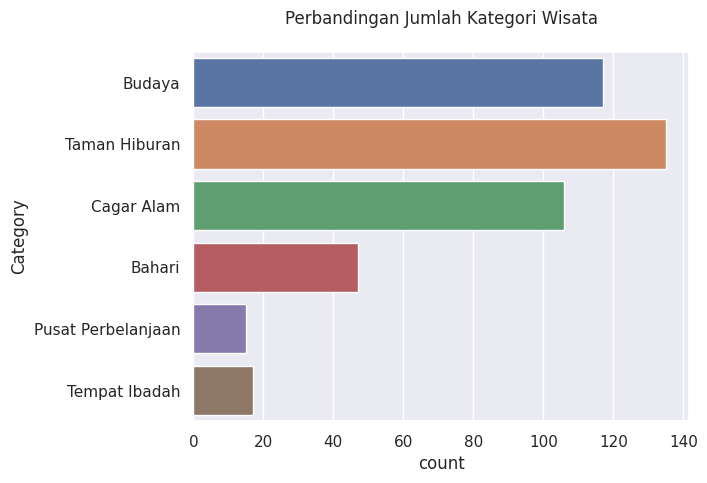

In [ ]:
# Membuat visualisasi jumlah kategori wisata di Kota Bandung

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata', pad=20)
plt.show()

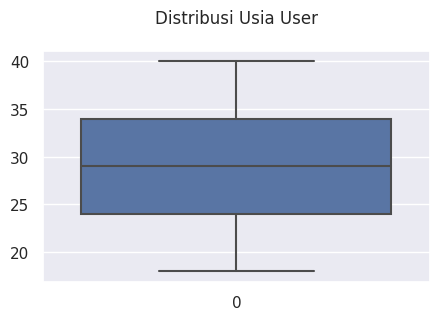

In [ ]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

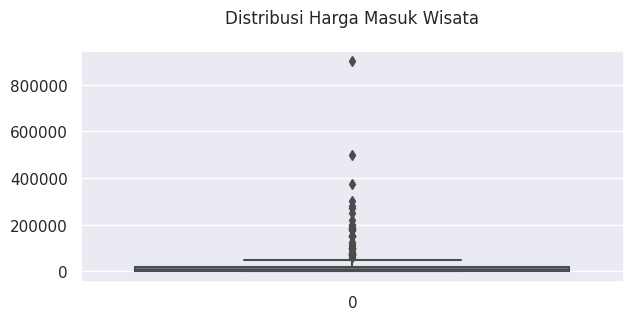

In [ ]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata', pad=20)
plt.show()

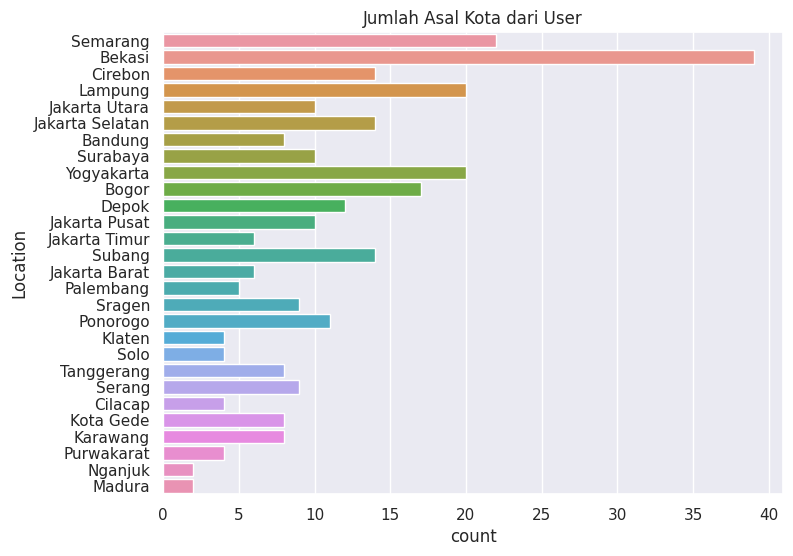

In [ ]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## 5. Persiapan Data untuk Pemodelan

### 5.1. Membuat Salinan Data rating

In [ ]:
# Membaca dataset untuk dilakukan encoding
 
df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


### 5.2. Melakukan Encoding

#### 5.2.1. Membuat Fungsi untuk Melakukan Encoding

In [ ]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

#### 5.2.2. Encoding dan Mapping Kolom User

In [ ]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

#### 5.2.3. Encoding dan Mapping Kolom Place

In [ ]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

### 5.3. Melihat Gambaran Data untuk Pemodelan

In [ ]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
 
# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
 
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])
 
print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 300, Number of Place: 437, Min Rating: 1.0, Max Rating: 5.0


In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings,user,place
6252,203,274,2.0,36,273
4684,126,206,5.0,112,205


## 6. Pemodelan Machine Learning dengan RecommenderNet

### 6.1. Membagi data train dan test

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### 6.2. Menyiapkan Model

#### 6.2.1. Inisialisasi Fungsi

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = layers.Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.places_bias = layers.Embedding(num_places, 1) # layer embedding places bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # memanggil layer embedding 3
    places_bias = self.places_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_places = tf.tensordot(user_vector, places_vector, 2) 
 
    x = dot_user_places + user_bias + places_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

#### 6.2.2. Inisialisasi Model

In [ ]:
model = RecommenderNet(num_users, num_place, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

#### 6.2.2. Inisialisasi Callbacks

In [ ]:
 class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

#### 6.2.3. Proses Training

In [ ]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks = [myCallback()]
)

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.6976 - root_mean_squared_error: 0.3486 - val_loss: 0.6965 - val_root_mean_squared_error: 0.3466
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6982 - root_mean_squared_error: 0.3490 - val_loss: 0.6964 - val_root_mean_squared_error: 0.3466
Epoch 3/100
250/250 [==============================] - 3s 13ms/step - loss: 0.6948 - root_mean_squared_error: 0.3466 - val_loss: 0.6961 - val_root_mean_squared_error: 0.3463
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6936 - root_mean_squared_error: 0.3458 - val_loss: 0.6958 - val_root_mean_squared_error: 0.3461
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6937 - root_mean_squared_error: 0.3458 - val_loss: 0.6954 - val_root_mean_squared_error: 0.3458
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6908 - root_mean_squared_error: 0.3438 - val_loss: 0.6953

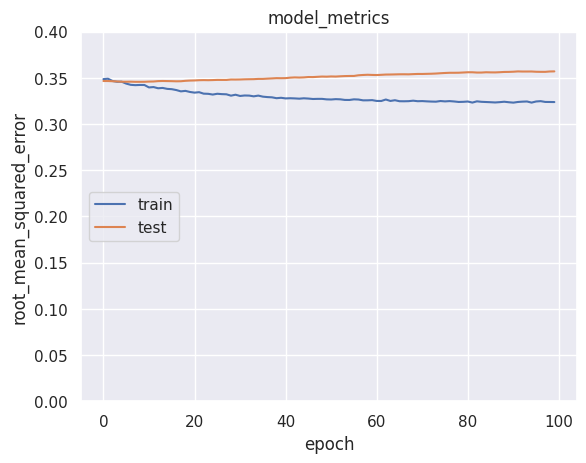

In [ ]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

## 7. Memprediksi Top 7 Rekomendasi

#### 7.1 Menyiapkan DataFrame untuk Menampilkan Hasil Rekomendasi

In [ ]:
# Menyiapkan dataframe
place_df = place[['Place_Id','Place_Name','Category','Rating','Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()

#### 7.2. Menyiapkan contoh User untuk Menampilkan Rekomendasi

#### 7.2.1 Mencari User

In [ ]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

#### 7.2.2. Mencari Lokasi yang belum Dikunjungi User

In [ ]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

### 7.3. Menampilkan Hasil Rekomendasi untuk User

In [ ]:
# Mengambil top 7 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)
 
top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Harga Tiket Masuk ', row.price, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)

13/13 [==============================] - 0s 1ms/step
Daftar rekomendasi untuk: User 97

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
Galeri Indonesia Kaya : Budaya
Gedung Agung Yogyakarta : Budaya
Curug Batu Templek : Cagar Alam
Tirto Argo Siwarak : Taman Hiburan
Gua Maria Kerep Ambarawa : Cagar Alam

------------------------------------------------------------
Top 7 place recommendation
------------------------------------------------------------
1 . Kampung Cina 
     Budaya , Harga Tiket Masuk  15000 , Rating Wisata  4.5 

2 . Puncak Gunung Api Purba - Nglanggeran 
     Cagar Alam , Harga Tiket Masuk  10000 , Rating Wisata  4.7 

3 . Pantai Baron 
     Bahari , Harga Tiket Masuk  10000 , Rating Wisata  4.4 

4 . Pantai Ngrenehan 
     Bahari , Harga Tiket Masuk  3000 , Rating Wisata  4.4 

5 . Teras Cikapundung BBWS 
     Taman Hiburan , Harga Tiket Masuk 